# Cas13 Guide MFE Prediction CNN

By: Priyanka Shrestha

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import neptune.new
from neptunecontrib.monitoring.keras import NeptuneMonitor
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
import re

### Load the training and testing data

In [19]:
# bring in only the columns of the sequence and guideScore
df = pd.read_csv('firstcoronavirustest_CasRxguides.csv', usecols=['GuideSeq', 'GuideScores'])

### Prepare Data

RNA sequences were encoded using vectors of dim-6, where the position of the 1.0 indicated which nucleotide was being encoded. A 1.0 in the 5th index indicated a non-ACGUT letter was encountered. 

In [24]:
def encodeRNA(sequences):
    encoded_rna = []
    for char in sequences:
        if(char == 'A'):
            encoded_rna.append([1.0,0.0,0.0,0.0,0.0,0.0])
        elif(char == 'C'):
            encoded_rna.append([0.0,1.0,0.0,0.0,0.0,0.0])
        elif(char == 'G'):
            encoded_rna.append([0.0,0.0,1.0,0.0,0.0,0.0])
        elif(char == 'U'):
            encoded_rna.append([0.0,0.0,0.0,1.0,0.0,0.0])
        elif(char == 'T'):
            encoded_rna.append([0.0,0.0,0.0,0.0,1.0,0.0])
        else:
            encode_rna.append([0.0,0.0,0.0,0,0.0,1.0])
    return encoded_rna


In [25]:
def prepare_rna(df):
    encoded_rna = []
    for i in range (len(df['GuideSeq'])):
        encoded_rna.append(encodeRNA(df['GuideSeq'][i]))
    return encoded_rna

In [26]:
encoded_rna = prepare_rna(df)

### Split data into trainig, validation, and testing data

In [28]:
x_train, x_test, y_train, y_test = train_test_split(encoded_rna, df['GuideScores'], test_size = 0.3, random_state = 4)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.3, random_state = 4,)


In [29]:
x_train = sequence.pad_sequences(x_train, dtype=float)
x_test = sequence.pad_sequences(x_test, dtype=float)
x_val = sequence.pad_sequences(x_val, dtype=float)

### Build Model

In [ ]:
model_params = {
        "input_shape" : [23,6],
        "lstm_hidden_size" : 200,
        "num_layers" : 6,
        "name" : "Cas13 Guide Score Prediction CNN"
    }

In [30]:
model = Sequential()
model.add(LSTM(200, input_shape=(23,6), activation ='tanh', return_sequences=True, dropout=0.2))
model.add(Conv1D(10,6))
model.add(Conv1D(20,3))
model.add(GlobalMaxPooling1D())
model.add(Dense(100))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 23, 200)           165600    
_________________________________________________________________
conv1d (Conv1D)              (None, 18, 10)            12010     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 20)            620       
_________________________________________________________________
global_max_pooling1d (Global (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 180,431
Trainable params: 180,431
Non-trainable params: 0
__________________________________________________

In [31]:
# compile model
model.compile(
    loss= keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(),
    metrics=['mean_squared_error']
    )

In [ ]:
# create a new experiment on Neptune.ai
neptune.init(
        api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYWFkZWM0ZDgtY2EzZi00YmU4LWE2OTktMmQ3OThiNDQ4YjU1In0=',
        project_qualified_name='shrestp/Cas13Guidescore')
neptune.create_experiment(model_params['name'], params=model_params)



In [32]:
#factor = factory by which the learning rate will be reduce new_lr = lr*factor
#patience = number of epochs with no improvement after which learning rate reduces
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,
                                  min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor= 'val_loss', min_delta=0, patience = 50, mode= 'auto')

MAX_EPOCHS = 500
callbacks = [NeptuneMonitor(), early_stop, reduce_lr]

In [33]:
# fit model
history = model.fit(
    x_train, y_train,
    batch_size=50,
    epochs=MAX_EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=callbacks
    )

Epoch 1/500
372/372 [==============================] - 13s 31ms/step - loss: 0.1346 - mean_squared_error: 0.1346 - val_loss: 0.0505 - val_mean_squared_error: 0.0505
Epoch 2/500
372/372 [==============================] - 11s 31ms/step - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0401 - val_mean_squared_error: 0.0401
Epoch 3/500
372/372 [==============================] - 11s 31ms/step - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 4/500
372/372 [==============================] - 11s 30ms/step - loss: 0.0656 - mean_squared_error: 0.0656 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
Epoch 5/500
372/372 [==============================] - 12s 32ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0267 - val_mean_squared_error: 0.0267
Epoch 6/500
372/372 [==============================] - 12s 33ms/step - loss: 0.0600 - mean_squared_error: 0.0600 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 7/50

### Plots

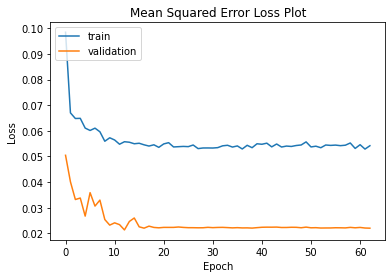

In [35]:
#  "Accuracy"
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Mean Squared Error Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [39]:
predict_list = model.predict(x_val).tolist()
predictions = [item for sublist in predict_list for item in sublist]
actual = y_val.tolist()

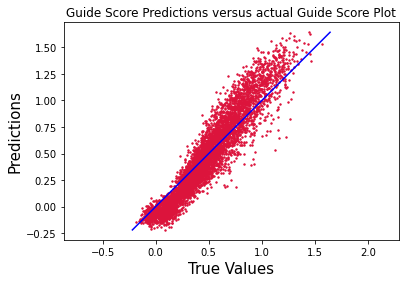

In [46]:
plt.title("Guide Score Predictions versus actual Guide Score Plot")
plt.scatter(predictions, actual, s=2, c = 'crimson')
plt.ylabel('P Values')
plt.xlabel('Predictions')
p1 = max(max(predictions), max(actual))
p2 = min(min(predictions), min(actual))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
#plt.savefig('final_mfe_predictions.png')
plt.show()

Plot difference in Predictions versus Actual Guide Score

In [41]:
differences = []
for i in range (len(actual)):
    differences.append(actual[i] - predictions[i])

Text(0, 0.5, 'Differences')

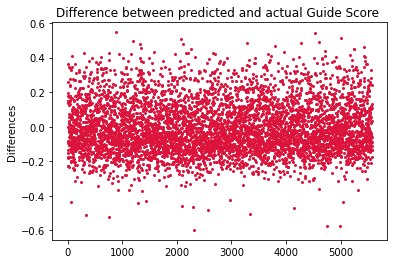

In [42]:
plt.title("Difference between predicted and actual Guide Score ")
plt.plot(differences, marker='o',linestyle='', c='crimson', markersize=2)
plt.ylabel('Differences')
#plt.savefig('final_mfe_prediction_differences.png')

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 23, 200)           165600    
_________________________________________________________________
conv1d (Conv1D)              (None, 18, 10)            12010     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 20)            620       
_________________________________________________________________
global_max_pooling1d (Global (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 180,431
Trainable params: 180,431
Non-trainable params: 0
__________________________________________________